Names:
1) Klaus Kades (Uni-id: fw448 Matrikelnr.: 3408463)

2) Lucas-Raphael Müller (Uni-id: al413 Matrikelnr.: 3205638)

3) Melanie Schellenberg (Uni-id: qh400 Matrikelnr.: 3146390)

4) Shuhan Xiao (Uni-id: kg410 Matrikelnr.: 3160697)


In [1]:
import pandas as pd 
import networkx as nx 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np
from collections import Counter

# Assignment 7
## Problem 7-1 Degree Correlations and Assortativity
### 1.

Get edge lists

In [2]:
!unzip assortativity_networks.zip

Archive:  assortativity_networks.zip
replace assortativity_networks/network-science.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
!ls assortativity_networks

blogs.txt           javax.txt           network-science.txt


Turn edge lists into undirected and unweighted networks without self-loops or multi-edges and print total number of nodes and edges:

In [5]:
def process_network(name="blogs", sep=r"\s+"): 
  data = pd.read_csv(f'./assortativity_networks/{name}.txt', sep=sep, index_col=None, names=['node1','node2'],)
  print(data.shape)
  #display(data.head())
  # remove multi-edges
  data = data.drop_duplicates(keep='first')
  #print(data.shape)
  G = nx.from_pandas_edgelist(data, source='node1',target='node2')
  # remove self-loops
  G.remove_edges_from(nx.selfloop_edges(G))
  # convert to undirected graph
  G = G.to_undirected()
  # print total number of nodes and edges
  print(f"Total number of nodes and edges of network {name}: {nx.info(G)}")
  return G

 * "blogs"

In [6]:
Gb = process_network(name="blogs")

(33430, 2)
Total number of nodes and edges of network blogs: Graph with 1224 nodes and 16715 edges


* "javax"

In [7]:
Gj = process_network(name="javax")

(138706, 2)
Total number of nodes and edges of network javax: Graph with 6120 nodes and 50290 edges


* "network-science"

In [9]:
Gn = process_network(name="network-science")

(2742, 2)
Total number of nodes and edges of network network-science: Graph with 1461 nodes and 2742 edges


### 2. 
Implement a function to compute the degree correlation matrix E containing the probabilities eij of
finding two nodes with degrees i and j at the end of a randomly selected link.

In [10]:
def compute_degree_correlation_matrix(G):
  degrees = [val for _, val in G.degree()]
  kmax = max(degrees)
  E = np.zeros((kmax,kmax))
  # iterate through edges to get degree list
  deg_list = []
  for u, v in G.edges:
    # find degrees of the nodes at the end of edge
    i = G.degree[u]
    j = G.degree[v]
    deg_list.append(tuple(sorted((i,j))))
  # count how many edges have nodes of degrees i and j at each end
  counts = Counter(deg_list)
  for i, j in counts.keys():
    # consider each edge twice
    E[i-1,j-1] += counts[(i,j)]/(2*G.number_of_edges())
    E[j-1,i-1] += counts[(i,j)]/(2*G.number_of_edges())
  return E

### 3.
Compute the degree correlation for each network from degree correlation matrix:


In [11]:
def plot_heat_maps(G, name, **args):
  E = compute_degree_correlation_matrix(G)
  # check sum
  print(f"Sum of elements e_ij: {np.sum(E)}")
  fig, ax = plt.subplots()
  im = ax.matshow(E, cmap='BuPu', origin='lower', **args)
  ax.figure.colorbar(im, ax=ax)
  ax.set_xlabel("k2")
  ax.set_ylabel("k1")
  ax.xaxis.set_ticks_position('bottom')
  ax.set_title(f"heat map for network {name}")

* "blogs" 

Sum of elements e_ij: 1.0000000000000002


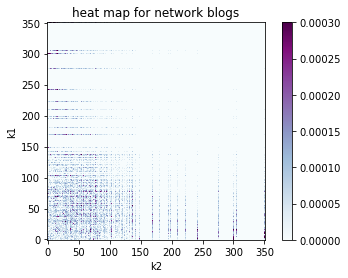

In [12]:
plot_heat_maps(Gb, "blogs", vmin=0.0, vmax = 0.0003)

The heatmaps has higher values not only across the main diagonal, but also close to the axes for higher values. This shows that some high degree nodes are linked to a lot of low degree nodes and vice versa, low degree nodes however are also likely to be linked to other low degree node. Upon visual assessment of the heatmap we can make the conclusion that the network is likely to be disassortative.


* "javax"

In [13]:
Ej = compute_degree_correlation_matrix(Gj)

Sum of elements e_ij: 1.0


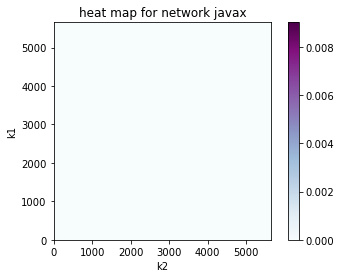

In [14]:
plot_heat_maps(Gj, "javax")

Text(0.5, 1.0, 'heat map for network javax')

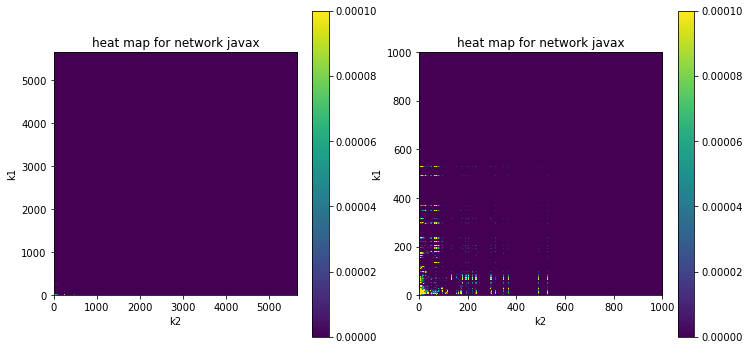

In [15]:
# repeat with another colorscale
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
im1 = ax1.matshow(Ej, origin='lower', vmax=0.0001)
ax1.figure.colorbar(im1, ax=ax1)
ax1.set_xlabel("k2")
ax1.set_ylabel("k1")
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title(f"heat map for network javax")
im2 = ax2.matshow(Ej, origin='lower', vmax=0.0001)
ax2.figure.colorbar(im2, ax=ax2)
ax2.set_xlabel("k2")
ax2.set_ylabel("k1")
plt.xlim([0,1000])
plt.ylim([0,1000])
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title(f"heat map for network javax")


A closer inspection of the heat map reveals that the highest values are distributed close to the origin and along the axes, similar to the heat map of the blogs network. We can also conclude that the network is most likely a disassortative network.


* "network-science"

Sum of elements e_ij: 1.0


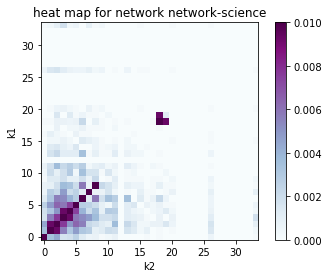

In [16]:
plot_heat_maps(Gn, "network-science", vmin=0.0, vmax = 0.01)

The heat map is darker along the main diagonal meaning that nodes are generally more likely to be connected to nodes of the same degree, this indicates that the network is assortative.

### 4. 

Implement a function to compute the average nearest neighbour degree $k_{nn}(k_i)$ of each node:

$k_{nn}(k_i) = \frac{1}{k_i} ∑_{j=1}^N A_{ij}k_j$

($A_{ij}k_j$ = neighbours of node $i$)

In [14]:
def compute_avg_knn_of_node(G, nbunch=None, get_ki=False): 
  if isinstance(nbunch, int):
    knn = 0
    ki = G.degree[nbunch]
    for n in G.neighbors(nbunch):
      knn += G.degree[n]/ki
  else: 
    # compute average nearest neighbour degree for more than one node
    knn = {}
    ki = []
    if nbunch is None:
      nbunch = G.nodes()
    #assert hasattr(nbunch, '__iter__'), type(nbunch)
    for i in nbunch:
      knn[i], ki_ = compute_avg_knn_of_node(G, nbunch=i, get_ki=True)
      ki.append(ki_)
  if get_ki:
    return knn, ki
  else: 
    return knn

Implement a second function to compute $k_{nn}(k)$, i.e., the averaged $k_{nn}(k_i)$ over
all nodes with the same degree $k_i =k$.

$k_{nn}(k) = ∑_{k'} k' P(k'|k)$

In [15]:
def compute_avg_knn_of_degk_nodes(G, k=None, get_k=False): 
  if isinstance(k, int):
    knn = 0
    n_k = 0
    for i in G.nodes():
      if G.degree[i] == k:
        n_k += 1
        knn += compute_avg_knn_of_node(G, i)
    knn = knn/n_k
  elif k is None:
    degrees = [val for _, val in G.degree()]
    knn = {}
    k = []
    for deg in set(degrees):
      knn[deg], k_ = compute_avg_knn_of_degk_nodes(G, k=deg, get_k=True)
      k.append(k_)
  if get_k:
    return knn, k
  else: 
    return knn

### 5. 
Create a scatter plot showing the average nearest neighbor degree $k_{nn}(k_i)$ of each
node as a function of $k_i$. In the same figure, also plot $k_{nn}(k)$, i.e., the averaged $k_{nn}(k_i)$ over all nodes
with the same degree.
 TODO: <k^2>/<k>

In [91]:
def plot_avg_knn_results(G, name):
  knn_ki, ki = compute_avg_knn_of_node(G, nbunch=None, get_ki=True)
  knn_k, k = compute_avg_knn_of_degk_nodes(G, k=None, get_k=True)
  plt.figure(figsize=(8,8))
  plt.scatter(ki, knn_ki.values())
  plt.scatter(k, knn_k.values())
  # plot degree correlation function of neutral network 
  avg_k = sum([val for _, val in G.degree()])/G.number_of_nodes()
  avg_k2 = sum([val**2 for _, val in G.degree()])/G.number_of_nodes()
  print(f"<k> = {avg_k}")
  print(f"<k^2> = {avg_k2}")
  plt.axhline(y=avg_k2/avg_k, color='r', linestyle='-')

  coef = np.polyfit(np.log(np.array(k)),np.log(np.fromiter(knn_k.values(),dtype=float)),1)
  print(f"fit result of a*k^mu: exponent mu = {coef[0]}")
  poly1d_fn = np.poly1d(coef) 
  plt.plot([min(k),max(k)], np.exp(poly1d_fn(np.log([min(k),max(k)]))), '--k') 

  plt.xlabel("degree k")
  plt.ylabel("nearest neighbour degree $k_{nn}$")
  plt.legend(["$<k^2>/<k>$",f"fit of $k_{{nn}}(k)$: $k^{{{coef[0]:.2f}}}$", "$k_{nn}(k_i)$","$k_{nn}(k)$"])
  plt.title(f"Average nearest neighbour degree for network {name}")
  plt.xscale("log")
  plt.yscale("log")


* "blogs"

<k> = 27.312091503267975
<k^2> = 2219.346405228758
fit result of a*k^mu: exponent mu = -0.1966008645957569


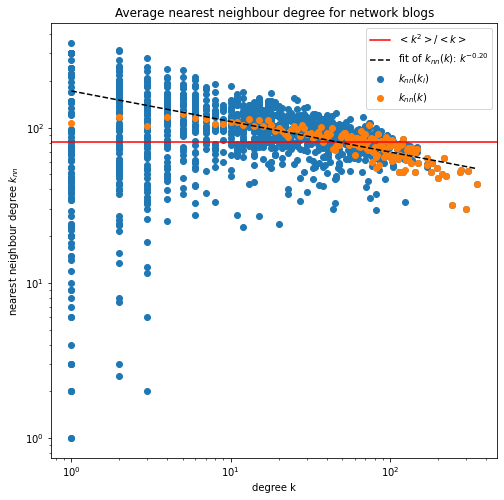

In [92]:
plot_avg_knn_results(Gb, "blogs")

Both $k_{nn}(k_i)$ and $k_{nn}(k)$ are generally decreasing with a negative slope, which is also the case for assortative networks. 
* "javax"

<k> = 16.434640522875817
<k^2> = 16299.350326797387
fit result of a*k^mu: exponent mu = -0.7702469918342446


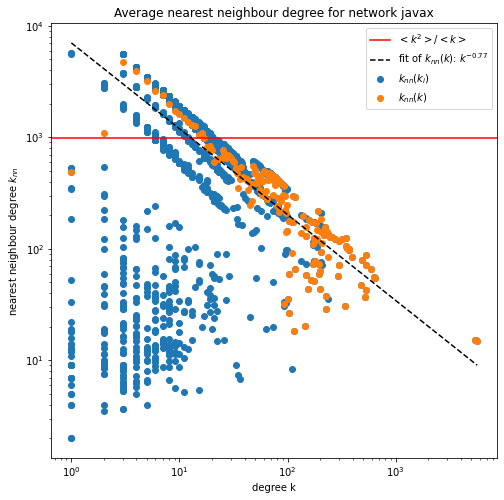

In [93]:
plot_avg_knn_results(Gj, "javax")

Two $k_{nn}(k_i)$ data points form clusters: One of the clusters is located in the lower left corner where the degrees $k$ and $k_{nn}$ are roughly below $10^2$. The other cluster shows are negative slope, starting from $k \sim 10^2$ and $k_{nn} \sim 10^2$ and roughly coincide with the $k_{nn}(k)$ data points. 
From the large negative slope it can be concluded that the network is disassortative.
* "network-science"

<k> = 3.753593429158111
<k^2> = 26.04517453798768
fit result of a*k^mu: exponent mu = 0.30611665100370716


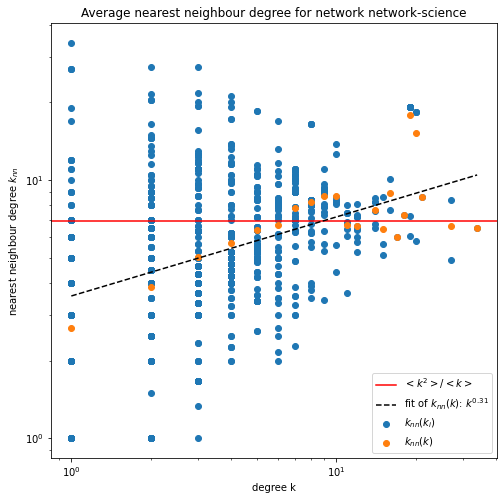

In [94]:
plot_avg_knn_results(Gn, "network-science")

The data points of $k_{nn}(k)$ show a positive slope, indicating that the network is assortative. The data points of $k_{nn}(k_i)$ however are scattered around <$k^2$> / < k > and don't show a general trend.


### 6. 
Implement a function to compute the degree correlation coefficient r.

In [20]:
def compute_deg_corr_coeff(G):
  degrees = [val for _, val in G.degree()]
  avg_k = sum(degrees)/G.number_of_nodes()
  # degree distribution p_k: 
  counts = nx.degree_histogram(G)
  pk = [c/G.number_of_nodes() for c in counts] # list starts from p(k = 0)
  kmax = len(pk)-1
  # probability of having a degree k node at the end of a random link q_k:
  qk = [k*pk[k]/avg_k for k in range(kmax+1)] # list starts from q(k = 0)
  # degree correlation matrix E:
  E = compute_degree_correlation_matrix(G) 
  # variance sigma^2:
  var = sum([k**2 * qk[k] for k in range(kmax+1)]) - (sum([k * qk[k] for k in range(kmax+1)]))**2
  # degree correlation coefficient r:
  r = sum((j+1)*(k+1)*(E[j][k]-qk[j+1]*qk[k+1])/var for j in range(kmax) for k in range(kmax))
  return r

# deg_list, counts = np.unique(degrees, return_counts=True))
# pk = counts/G.number_of_nodes()

Apply function to all three networks:

* "blogs"

In [21]:
r = compute_deg_corr_coeff(Gb)
print(f"degree correlation coefficient (blogs) r = {r}")
# check with function implemented in networkx
print(nx.degree_pearson_correlation_coefficient(Gb))
print(nx.degree_assortativity_coefficient(Gb))


degree correlation coefficient (blogs) r = -0.2212328638045546
-0.22123286380455434
-0.22123286380455423


r < 0, which is the case for disassortative networks.

* "javax"

In [22]:
r = compute_deg_corr_coeff(Gj)
print(f"degree correlation coefficient (javax) r = {r}")
# check with function implemented in networkx
print(nx.degree_pearson_correlation_coefficient(Gj))
print(nx.degree_assortativity_coefficient(Gj))

degree correlation coefficient (javax) r = -0.2327051928360141
-0.23270519283601343
-0.23270519283601443


r < 0, this indicates that the network is also disassortative.

* "network-science"

In [23]:
r = compute_deg_corr_coeff(Gn)
print(f"degree correlation coefficient (network-science) r = {r}")
# check with function implemented in networkx
print(nx.degree_pearson_correlation_coefficient(Gn))
print(nx.degree_assortativity_coefficient(Gn))

degree correlation coefficient (network-science) r = 0.4616224667525837
0.46162246675258267
0.4616224667525835


r > 0, the network-science network is assortative.

### 7.
As shown in the previous parts, all three networks provide the same results: the "blogs" and "javax" network are both disassortative, the "network-science" network is assortative.

Advantages and disadvantages of each method:

(1) heat maps: 
  * (+) Requires fewer steps than the other methods: Only the computation and plotting of the degree correlation matrix E are necessary. Besides telling us whether whether the network is assortative or disassortative, the heat maps also provide additional information about the network topology.

  $⊳$ Makes sense to use if the networks is small (so that the matrix E is also small).
  * (-) Relies on qualitative visual assessments, which can be inaccurate or imprecise. Adjustments of the (colour) scale might also also necessary depending on the values and size of E.

(2) degree correlation function $k_{nn}(k)$ vs $k$ scatter plot 
  * (+) Provides additional information about the network's topology, for example if the network displays the phenomenon of structural disassortativity.
  
  $⊳$ Makes sense to use if one is interested in details of the network's topology.
  * (-) Additional fit of the data points necessary to get a quantitative measure for the network's assortativity ($\mu$). 

(3) degree correlation coefficient r
  * (+) Provides a quantitative measure for the network's assortativity, easy to interpret 

  $⊳$ Makes sense to use if one is only interested in a quantitative value that captures the correlations in the network.
  * (-) Doesn't provide additional information about the network's topology. More steps required than for the heat maps method.

